## 기본 세팅

In [ ]:
import torch.nn as nn
import torch

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## CNN + Classifier

In [ ]:
# Channel Attention (SE block)
class ChannelGate(nn.Module):
    def __init__(self, gate_channels, reduction_ratio=16):
        super(ChannelGate, self).__init__()
        self.mlp = nn.Sequential(
            nn.Flatten(),
            nn.Linear(gate_channels, gate_channels // reduction_ratio),
            nn.ReLU(),
            nn.Linear(gate_channels // reduction_ratio, gate_channels)
        )

    def forward(self, x):
        avg_pool = F.avg_pool1d(x, x.size(2), stride=x.size(2))
        channel_att = self.mlp(avg_pool)
        scale = torch.sigmoid(channel_att).unsqueeze(2).expand_as(x)
        return x * scale

# CNN 피라미드 (5 단계)
class SleePyCoBackbone(nn.Module):
    def __init__(self, config):
        super(SleePyCoBackbone, self).__init__()
        self.training_mode = config['training_params']['mode']

        self.init_layer = self.make_layers(1, 64, 2, maxpool_size=None, first=True)
        self.layer1 = self.make_layers(64, 128, 2, maxpool_size=5)
        self.layer2 = self.make_layers(128, 192, 3, maxpool_size=5)
        self.layer3 = self.make_layers(192, 256, 3, maxpool_size=5)
        self.layer4 = self.make_layers(256, 256, 3, maxpool_size=5)

        if self.training_mode in ['scratch', 'freezefinetune']:
            self.fp_dim = config['feature_pyramid']['dim']
            self.num_scales = config['feature_pyramid']['num_scales']
            self.conv_c5 = nn.Conv1d(256, self.fp_dim, 1)
            if self.num_scales > 1:
                self.conv_c4 = nn.Conv1d(256, self.fp_dim, 1)
            if self.num_scales > 2:
                self.conv_c3 = nn.Conv1d(192, self.fp_dim, 1)

    def make_layers(self, in_channels, out_channels, n_layers, maxpool_size, first=False):
        layers = []
        if not first:
            layers.append(nn.MaxPool1d(kernel_size=maxpool_size, stride=maxpool_size))
        for i in range(n_layers):
            layers.append(nn.Conv1d(in_channels, out_channels, kernel_size=3, padding=1))
            layers.append(nn.BatchNorm1d(out_channels))
            if i == n_layers - 1:
                layers.append(ChannelGate(out_channels))
            layers.append(nn.PReLU())
            in_channels = out_channels
        return nn.Sequential(*layers)

    def forward(self, x):
        out = []
        c1 = self.init_layer(x)
        c2 = self.layer1(c1)
        c3 = self.layer2(c2)
        c4 = self.layer3(c3)
        c5 = self.layer4(c4)

        if self.training_mode == 'pretrain':
            out.append(c5)
        elif self.training_mode in ['scratch', 'freezefinetune']:
            p5 = self.conv_c5(c5)
            out.append(p5)
            if self.num_scales > 1:
                p4 = self.conv_c4(c4)
                out.append(p4)
            if self.num_scales > 2:
                p3 = self.conv_c3(c3)
                out.append(p3)
        return out

# Classifier
class SimpleClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(SimpleClassifier, self).__init__()
        self.fc = nn.Linear(input_dim, num_classes)

    def forward(self, x):
        x = self.fc(x)
        return x

# MainModel (피라미드 + SE)
class MainModel(nn.Module):
    def __init__(self, config):
        super(MainModel, self).__init__()
        self.cfg = config
        self.bb_cfg = config['backbone']
        self.training_mode = config['training_params']['mode']

        self.feature = SleePyCoBackbone(config)
        if self.bb_cfg['dropout']:
            self.dropout = nn.Dropout(p=0.5)

        if self.training_mode == 'scratch':
            self.classifier = SimpleClassifier(config['classifier']['embed_dim'], config['classifier']['n_classes'])

        # 추가: EEG, EOG 따로 Conv1d 처리 후 합치기
        self.eeg_conv = nn.Conv1d(1, 1, kernel_size=1)  # 그대로 통과시키는 역할
        self.eog_conv = nn.Conv1d(1, 1, kernel_size=1)

    def forward(self, x):
        # x: (B, 2, 3000)  (EEG + EOG)

        eeg = x[:, 0:1, :]  # (B, 1, 3000)
        eog = x[:, 1:2, :]  # (B, 1, 3000)

        eeg = self.eeg_conv(eeg)  # (B, 1, 3000)
        eog = self.eog_conv(eog)  # (B, 1, 3000)

        x = eeg + eog  # (B, 1, 3000)  ← 합치기!

        features = self.feature(x)

        outputs = []
        for feature in features:
            if self.bb_cfg['dropout']:
                feature = self.dropout(feature)
            feature = feature.transpose(1, 2)
            output = self.classifier(feature)
            outputs.append(output)

        return outputs

# 기본 설정
config = {
    'backbone': {
        'name': 'SleePyCo',
        'dropout': True,
        'init_weights': True,
    },
    'training_params': {
        'mode': 'scratch',
    },
    'proj_head': {
        'name': 'Linear',
        'dim': 128,
    },
    'feature_pyramid': {
        'dim': 256,
        'num_scales': 1,
    },
    'classifier': {
        'n_classes': 5,
        'embed_dim': 256,
        'type': 'Linear'
    }
}

# 모델 인스턴스 생성
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MainModel(config).to(device)
print("✅ SleepyCo 모델 준비 완료!")

✅ SleepyCo 모델 준비 완료!


## 데이터 로드

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.metrics import accuracy_score, f1_score, recall_score, classification_report

# SleepEDF_EpochDataset 클래스 정의
class SleepEDF_EpochDataset(Dataset):
    def __init__(self, data, labels, normalize=True):
        self.data = data
        self.labels = labels
        self.normalize = normalize

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = self.data[idx]  # shape: (2, 3000)
        y = self.labels[idx]
        if self.normalize:
            x = (x - x.mean()) / (x.std() + 1e-5)
        return x, y

# 데이터 로드 및 DataLoader 준비
def prepare_dataloader(batch_size=64):
    merged_path = "/content/drive/MyDrive/sleep_segments/merged_sleep_dataset.pt"
    segmented_data, labels = torch.load(merged_path)
    dataset = SleepEDF_EpochDataset(segmented_data, labels)
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    return train_loader, val_loader, val_dataset

In [ ]:
#데이터 로드 함수 적용
import torch.nn.functional as F
from sklearn.metrics import accuracy_score
train_loader, val_loader, val_dataset = prepare_dataloader(batch_size=64)

In [ ]:
# 옵티마이저 및 손실 함수 정의
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

In [ ]:
# Training Loop 20 에폭 돌림
best_acc = 0
for epoch in range(20):
    model.train()
    total_loss = 0

    for x_batch, label_batch in train_loader:
        x_batch = x_batch.to(device)
        label_batch = label_batch.to(device)

        optimizer.zero_grad()
        outputs = model(x_batch)

        B, L, C = outputs[0].shape  # outputs[0] 사용
        outputs = outputs[0].reshape(B * L, C)
        label_batch = label_batch.repeat_interleave(L)

        loss = criterion(outputs, label_batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader):.4f}")

    # Validation
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for x_batch, label_batch in val_loader:
            x_batch = x_batch.to(device)
            label_batch = label_batch.to(device)

            outputs = model(x_batch)[0]
            B, L, C = outputs.shape
            outputs = outputs.reshape(B * L, C)
            preds = torch.argmax(outputs, dim=1)

            label_batch = label_batch.repeat_interleave(L)

            all_preds.append(preds.cpu())
            all_labels.append(label_batch.cpu())

    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)

    acc = accuracy_score(all_labels, all_preds)
    if acc > best_acc:
        best_acc = acc
        torch.save(model.state_dict(), '/content/presentable_cnnclassifiermodel.pt')

print("학습완료")

Epoch 1, Loss: 0.0289
Epoch 2, Loss: 0.0283
Epoch 3, Loss: 0.0270
Epoch 4, Loss: 0.0263
Epoch 5, Loss: 0.0251
Epoch 6, Loss: 0.0245
Epoch 7, Loss: 0.0242
Epoch 8, Loss: 0.0234
Epoch 9, Loss: 0.0219
Epoch 10, Loss: 0.0216
Epoch 11, Loss: 0.0206
Epoch 12, Loss: 0.0212
Epoch 13, Loss: 0.0202
Epoch 14, Loss: 0.0198
Epoch 15, Loss: 0.0189
Epoch 16, Loss: 0.0183
Epoch 17, Loss: 0.0187
Epoch 18, Loss: 0.0183
Epoch 19, Loss: 0.0172
Epoch 20, Loss: 0.0165
학습완료


In [ ]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, classification_report

# 평가
def evaluate(all_labels, all_preds):
    acc = accuracy_score(all_labels, all_preds)
    macro_f1 = f1_score(all_labels, all_preds, average='macro')
    weighted_f1 = f1_score(all_labels, all_preds, average='weighted')

    # 각 클래스별 Recall 계산 (0~4 포함)
    recalls = recall_score(all_labels, all_preds, average=None, labels=[0, 1, 2, 3, 4])

    print(f"Accuracy: {acc:.4f}")
    print(f"Macro F1: {macro_f1:.4f}")
    print(f"Weighted F1: {weighted_f1:.4f}")

    for i, r in enumerate(recalls):
        print(f"Recall (Class {i}): {r:.4f}")

    return acc, macro_f1, weighted_f1, recalls

# 실행
evaluate(all_labels.numpy(), all_preds.numpy())

Accuracy: 0.9149
Macro F1: 0.7638
Weighted F1: 0.9140
Recall (Class 0): 0.9839
Recall (Class 1): 0.4166
Recall (Class 2): 0.8353
Recall (Class 3): 0.8035
Recall (Class 4): 0.7947


(0.9149007839294464,
 0.7637764010069644,
 0.9139569265630827,
 array([0.98392659, 0.41655607, 0.83530366, 0.80348584, 0.79469477]))

## 각 클래스마다 몇개 맞췄나

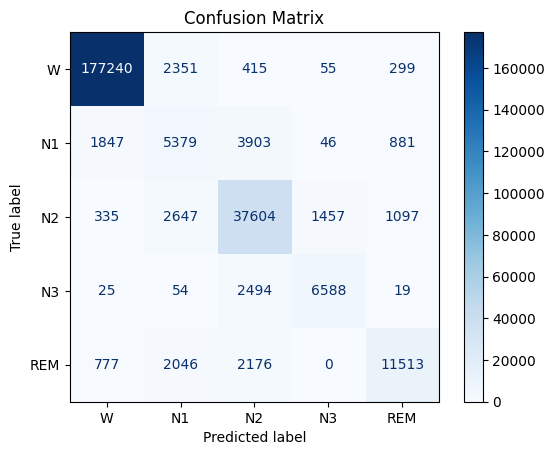

In [ ]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
class_names = ['W', 'N1', 'N2', 'N3', 'REM']
cm = confusion_matrix(all_labels, all_preds)
ConfusionMatrixDisplay(cm, display_labels=class_names).plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [ ]:
import numpy as np

## 예측 성과 비교

In [ ]:
# 1. 전체 예측 샘플 수
total_samples = len(all_preds)
print(f"총 예측 샘플 수: {total_samples}\n")

# 2. 각 클래스별 예측 개수
pred_counts = np.sum(cm, axis=0)
print("예측된 각 클래스별 개수:")
for name, count in zip(class_names, pred_counts):
    print(f"{name}: {count}")
print()

# 3. 각 클래스별 정답 맞춘 개수
correct_counts = np.diag(cm)
print("정확히 예측된 개수 (맞춘 개수):")
for name, count in zip(class_names, correct_counts):
    print(f"{name}: {count}")
print()

# 4. 전체 맞춘 개수 및 정확도
total_correct = np.sum(correct_counts)
accuracy = total_correct / total_samples
print(f"총 맞춘 개수: {total_correct} / {total_samples}")
print(f"정확도: {accuracy:.2%}")

총 예측 샘플 수: 261248

예측된 각 클래스별 개수:
W: 180224
N1: 12477
N2: 46592
N3: 8146
REM: 13809

정확히 예측된 개수 (맞춘 개수):
W: 177240
N1: 5379
N2: 37604
N3: 6588
REM: 11513

총 맞춘 개수: 238324 / 261248
정확도: 91.23%


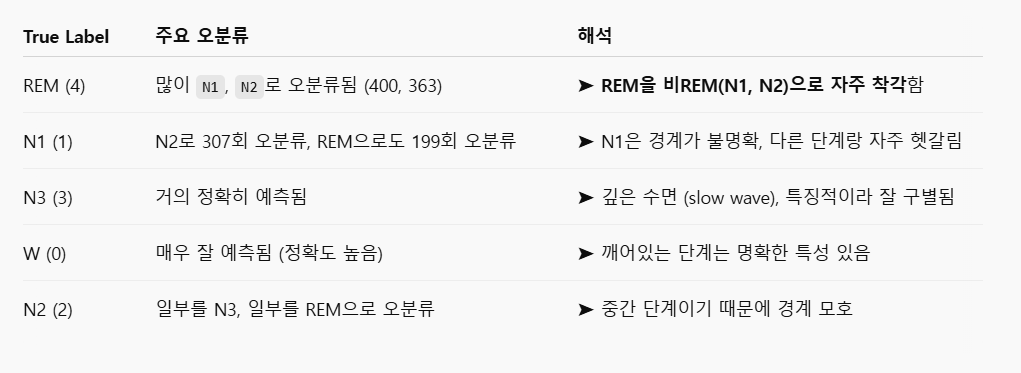

In [ ]:
print(outputs.shape)

## 결정 근거 확인

Grad-CAM에서 보여주는 것은 "예측의 근거가 된 시간 구간" 임

학습한 모델로 무작위로 가짜로 만든 샘플을 예측하고 그 근거를 시간대별로 어디에 가중치 높게 뒀는지 시각화해서 보여주는거임

해당 수면 스테이지 근거가 한 에폭 기준 어디에 쏠려있는지 확인한 코드

이거 어떻게 구하는지에 대해선 더 조사 필요한 상태인데 CNN 기반 모델에서 예측 근거 판단에 유용하다고 함

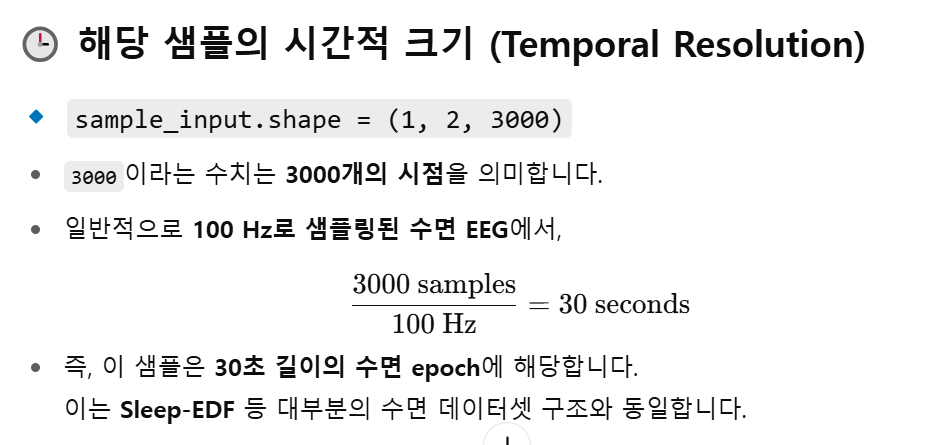